# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

import math

# Constants

In [2]:
START = .0001
END = .02
TIMESTEPS = 300

IMG_SIZE = 64
BATCH_SIZE = 128

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


# Forward Process

In [4]:
def beta_scheduler(start=START, end=END, timesteps=TIMESTEPS):
  return torch.linspace(start=start, end=end, steps=timesteps)

In [5]:
betas = beta_scheduler()
alphas = 1. - betas

alpha_bars = torch.cumprod(alphas, axis=0)
alpha_bars_prev = F.pad(alpha_bars[:-1], (1, 0), value=1.0)
sqrt_one_over_alpha_bars = torch.sqrt(1. / alphas)
sqrt_alpha_bars = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1. - alpha_bars)

posterior_variance = betas * (1. - alpha_bars_prev) / (1. - alpha_bars)

In [6]:
def get_index_for_batch(vals, t, x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device)

In [7]:
def forward_process(x_0, t):
  noise = torch.randn_like(x_0)
  
  sqrt_alpha_bars_for_batch = get_index_for_batch(sqrt_alpha_bars, t, x_0.shape)
  sqrt_one_minus_alpha_bars_for_batch = get_index_for_batch(
      sqrt_one_minus_alpha_bars, t, x_0.shape
  )
  
  return sqrt_alpha_bars_for_batch.to(device) * x_0.to(device) + \
      sqrt_one_minus_alpha_bars_for_batch * noise.to(device), noise.to(device)

In [8]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)
    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)
    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), 
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

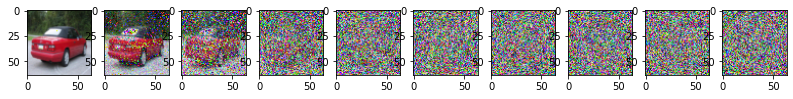

In [9]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(TIMESTEPS / num_images)

for idx in range(0, TIMESTEPS, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, (idx / stepsize) + 1)
    image, noise = forward_process(image, t)
    show_tensor_image(image.cpu())

# Backward Process

In [10]:
class UNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, time_embedding_dim, up=False):
    super().__init__()
    
    self.time_mlp = nn.Linear(time_embedding_dim, out_channels)

    if up:
      self.conv1 = nn.Conv2d(2 * in_channels, out_channels, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
      self.transform = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.batch_norm_1 = nn.BatchNorm2d(out_channels)
    self.batch_norm_2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x, t):
    h = self.batch_norm_1(self.relu(self.conv1(x)))

    time_embed = self.relu(self.time_mlp(t))
    time_embed = time_embed[(...,) + (None, ) * 2]
    h = h + time_embed
    h = self.batch_norm_2(self.relu(self.conv2(h)))

    return self.transform(h)

In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, x):
    half_dim = self.dim // 2

    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = x[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

    return embeddings

In [12]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)

    time_embedding_dim = 32

    self.time_mlp = nn.Sequential(
      SinusoidalPositionEmbeddings(time_embedding_dim),
      nn.Linear(time_embedding_dim, time_embedding_dim),
      nn.ReLU()
    )

    self.conv_0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

    self.down = nn.ModuleList([
        UNetBlock(down_channels[i], down_channels[i + 1], time_embedding_dim) \
          for i in range(len(down_channels) - 1)
    ])
    self.up = nn.ModuleList([
        UNetBlock(up_channels[i], up_channels[i + 1], time_embedding_dim, True) \
          for i in range(len(up_channels) - 1)
    ])

    self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

  def forward(self, x, t):
    t = self.time_mlp(t)

    x = self.conv_0(x)

    cache = []
    for down in self.down:
      x = down(x, t)
      cache.append(x)

    for up in self.up:
      residual_input = cache.pop()
      x = torch.cat((x, residual_input), dim=1)
      x = up(x, t)
    
    return self.output(x)

In [13]:
model = UNet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


UNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): UNetBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): UNetBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

## Loss Function

In [14]:
loss_func = nn.MSELoss(reduction='mean')
def loss_function(x_0, x_hat):
  return loss_func(x_0, x_hat)

# Sampling

In [15]:
@torch.no_grad()
def sample_timestep(x, t):
  betas_for_batch = get_index_for_batch(betas, t, x.shape)
  sqrt_one_minus_alpha_for_batch = get_index_for_batch(
    sqrt_one_minus_alpha_bars, t, x.shape
  )
  sqrt_one_over_alpha_bars_for_batch = get_index_for_batch(
    sqrt_one_over_alpha_bars, t, x.shape    
  )
  
  model_mean = sqrt_one_over_alpha_bars_for_batch * (
      x - betas_for_batch * model(x, t) / sqrt_one_minus_alpha_for_batch
  )

  posterior_variance_for_batch = get_index_for_batch(
      posterior_variance, t, x.shape
  )

  if t == 0:
    return model_mean
  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_for_batch) * noise

In [16]:
@torch.no_grad()
def sample_plot_image():
    
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(TIMESTEPS / num_images)

    for i in range(0,TIMESTEPS)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show() 

# Train

Epoch 1 | Loss: 0.09485119581222534 


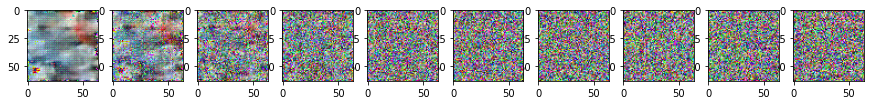

Epoch 2 | Loss: 0.0773770734667778 


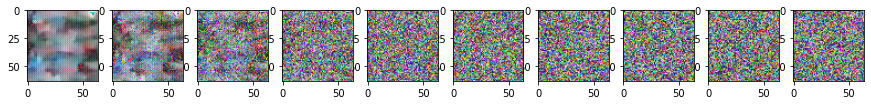

Epoch 3 | Loss: 0.0641651302576065 


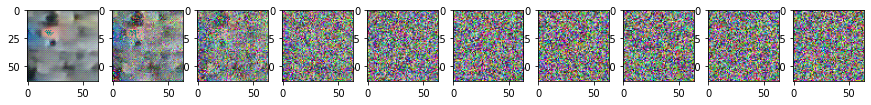

Epoch 4 | Loss: 0.06503738462924957 


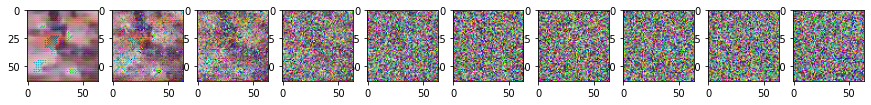

Epoch 5 | Loss: 0.055408403277397156 


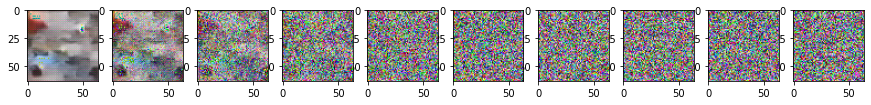

Epoch 6 | Loss: 0.055626481771469116 


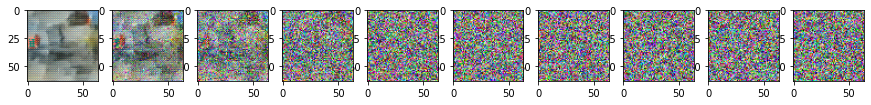

Epoch 7 | Loss: 0.05690385028719902 


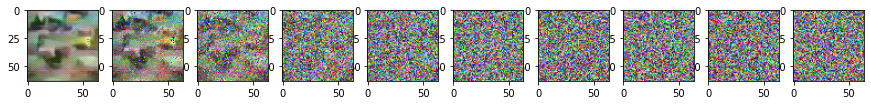

Epoch 8 | Loss: 0.056444358080625534 


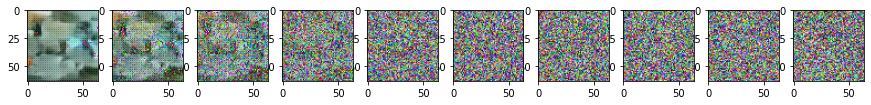

Epoch 9 | Loss: 0.054645806550979614 


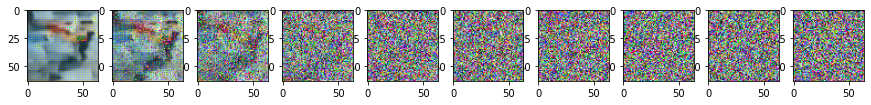

Epoch 10 | Loss: 0.07084271311759949 


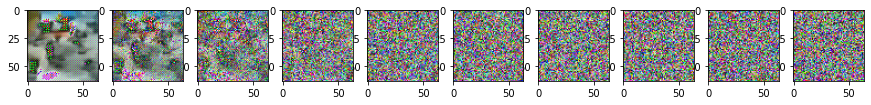

Epoch 11 | Loss: 0.060674723237752914 


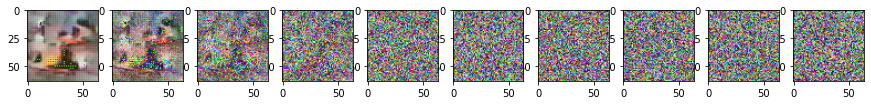

Epoch 12 | Loss: 0.0582880936563015 


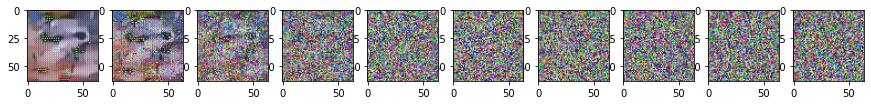

Epoch 13 | Loss: 0.057317256927490234 


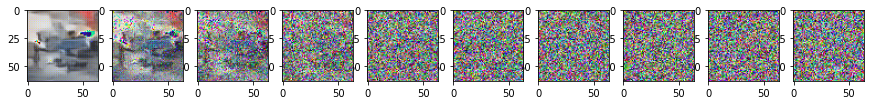

Epoch 14 | Loss: 0.062353454530239105 


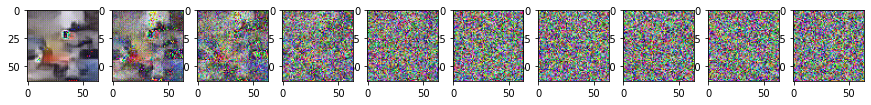

Epoch 15 | Loss: 0.046188026666641235 


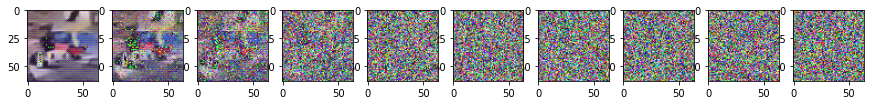

Epoch 16 | Loss: 0.05965304374694824 


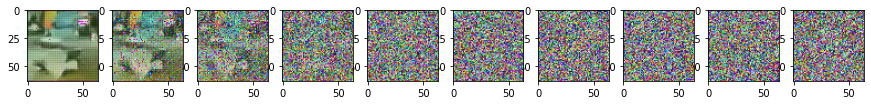

Epoch 17 | Loss: 0.051607176661491394 


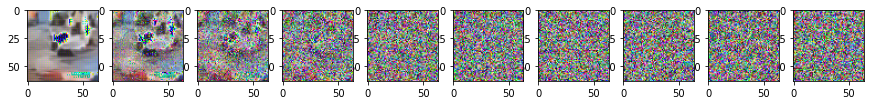

Epoch 18 | Loss: 0.05185161158442497 


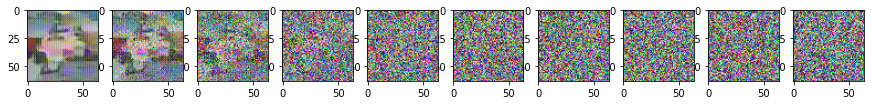

Epoch 19 | Loss: 0.05320820212364197 


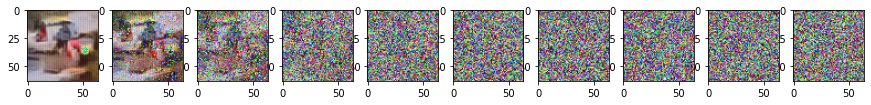

Epoch 20 | Loss: 0.05312952399253845 


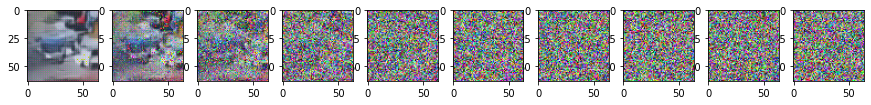

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
  for step, batch in enumerate(dataloader):
    images, _ = batch
    images = images.to(device)

    optimizer.zero_grad()

    t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,)).to(device).long()
    noisy_image, noise = forward_process(images, t)
    noise_pred = model(noisy_image, t)
    loss = loss_function(noise, noise_pred)
    loss.backward()
    optimizer.step()
  
  print(f"Epoch {epoch} | Loss: {loss.item()} ")
  sample_plot_image()